Basic code using moving average comparison between 10d and 50d.

Two Optimization Targets => ?

Small Moving Average
Larger Moving Average

Highest value of holdings at end is goal?

Other goals: minimize loss?

In [7]:
## Get BTC/AUD from Kraken
import ccxt
kraken = ccxt.kraken()
ticker = kraken.fetch_ticker('BTC/AUD')
price = ticker['last']

In [8]:
import ccxt
import datetime
import pandas as pd

kraken = ccxt.kraken()
# Load markets
kraken.load_markets()
# Define the trading pair and the timeframe
symbol = 'BTC/AUD' # Remember to change kraken.fetch_ticker if changing
candle_timeframe = '1d'
# Define the start and end dates
iso8601_tail = 'T00:00:00Z'
current_date = datetime.date.today()
timeframe = current_date - datetime.timedelta(days=365*2) # Two Years is 365*2
start_date = str(timeframe)+iso8601_tail
start_ts = kraken.parse8601(start_date)
# The amount of days to fetch.
# 720 is the maximum. Minus 1 as current day not complete.
limit = 719
# Debug Print Statements
print(f"Start Date ISO: {kraken.iso8601(start_ts)}")
# 
ohlcv_data = kraken.fetch_ohlcv(symbol, candle_timeframe, start_ts, limit)
# Convert the data to a Pandas DataFrame and set column names
ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
# Convert the timestamp to a human-readable datetime format
ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')
print(ohlcv_df)
ohlcv_df.to_pickle('dh2.pkl')
ohlcv_df.to_csv('raw_data.csv', index=False)

Start Date ISO: 2021-04-26T00:00:00.000Z
     timestamp     open     high      low    close     volume
0   2021-05-07  72544.1  75014.2  71527.6  73322.7  12.533144
1   2021-05-08  73772.5  76050.8  73119.9  75195.7  18.172034
2   2021-05-09  75312.3  75995.9  72184.5  74452.5  14.416112
3   2021-05-10  74588.7  76085.4  69500.0  71760.6  25.485468
4   2021-05-11  71760.0  73025.0  69949.0  72914.0  27.154785
..         ...      ...      ...      ...      ...        ...
714 2023-04-21  41884.9  42201.9  40638.8  40742.7  21.284550
715 2023-04-22  40800.5  41831.1  40675.0  41773.0   7.550956
716 2023-04-23  41771.7  41771.7  41105.8  41365.0   4.547375
717 2023-04-24  41365.0  41926.1  40406.2  41044.4  11.390838
718 2023-04-25  41046.1  42710.0  40860.8  42651.0   9.141922

[719 rows x 6 columns]


In [9]:
import ccxt
import datetime
import pandas as pd

import matplotlib.pyplot as plt

kraken = ccxt.kraken()

# Load markets
kraken.load_markets()

dh_df = pd.read_pickle('dh2.pkl')

print(dh_df)
print()

     timestamp     open     high      low    close     volume
0   2021-05-07  72544.1  75014.2  71527.6  73322.7  12.533144
1   2021-05-08  73772.5  76050.8  73119.9  75195.7  18.172034
2   2021-05-09  75312.3  75995.9  72184.5  74452.5  14.416112
3   2021-05-10  74588.7  76085.4  69500.0  71760.6  25.485468
4   2021-05-11  71760.0  73025.0  69949.0  72914.0  27.154785
..         ...      ...      ...      ...      ...        ...
714 2023-04-21  41884.9  42201.9  40638.8  40742.7  21.284550
715 2023-04-22  40800.5  41831.1  40675.0  41773.0   7.550956
716 2023-04-23  41771.7  41771.7  41105.8  41365.0   4.547375
717 2023-04-24  41365.0  41926.1  40406.2  41044.4  11.390838
718 2023-04-25  41046.1  42710.0  40860.8  42651.0   9.141922

[719 rows x 6 columns]



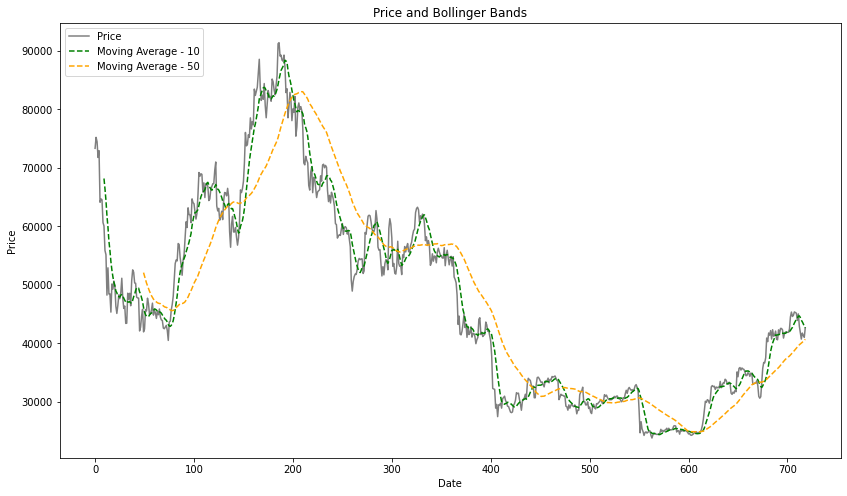

In [10]:
from ta.volatility import BollingerBands

short_window = 10 ### optimization target
medium_window = 50 ### optimization target
#long_window = 100

indicator_bb = BollingerBands(close=dh_df["close"], window=short_window, window_dev=2)
indicator_bb_m = BollingerBands(close=dh_df["close"], window=medium_window, window_dev=2)
#indicator_bb_l = BollingerBands(close=dh_df["close"], window=long_window, window_dev=2)

# Add Bollinger Bands features
dh_df['mavg_s'] = indicator_bb.bollinger_mavg()
dh_df['mavg_m'] = indicator_bb_m.bollinger_mavg()
#dh_df['mavg_l'] = indicator_bb_l.bollinger_mavg()


dh_df['bb_bbh'] = indicator_bb.bollinger_hband()
dh_df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
dh_df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
dh_df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

#print(dh_df)

# Plot the price and Bollinger Bands
plt.figure(figsize=(14, 8))
plt.plot(dh_df['close'], label='Price', alpha=0.5, color='black')
plt.plot(dh_df['mavg_s'], label=f'Moving Average - {short_window}', linestyle='--', color='green')
plt.plot(dh_df['mavg_m'], label=f'Moving Average - {medium_window}', linestyle='--', color='orange')
#plt.plot(dh_df['mavg_l'], label=f'Moving Average - {long_window}', linestyle='--', color='red')

#plt.plot(dh_df['bb_bbh'], label='Bollinger Bands High', linestyle='--', color='blue')
#plt.plot(dh_df['bb_bbl'], label='Bollinger Bands Low', linestyle='--', color='blue')


plt.title('Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.show()

In [11]:
import math
count = 0
toggle = False

fiat_money = 100
btc_money = 0
fee = 0.02 # Each buy or sell event costs 2% of current holdings.

for index, row in dh_df.iterrows():
    if not math.isnan(row['mavg_m']): # Wait until mavg_m is initialized
        if toggle:
            if row['mavg_s'] > row['mavg_m']:
                toggle = False
                count += 1
                fiat_money = ( btc_money * row['close'] ) * (1 - fee)
                btc_money = 0
                print(f"{index} {row['timestamp']}, {fiat_money}")
        else:
            if row['mavg_m'] > row['mavg_s']: # Will be triggered first
                toggle = True
                count += 1
                btc_money = ( fiat_money / row['close'] ) * (1 - fee)
                fiat_money = 0
                print(f"Day:{index},  Date: {row['timestamp']}, {btc_money * row['close']}")



Day:49,  Date: 2021-06-25 00:00:00, 98.0
82 2021-07-28 00:00:00, 124.17580700500356
Day:137,  Date: 2021-09-21 00:00:00, 121.69229086490348
152 2021-10-06 00:00:00, 160.70699296121165
Day:201,  Date: 2021-11-24 00:00:00, 157.49285310198744
281 2022-02-12 00:00:00, 114.85203756130528
Day:291,  Date: 2022-02-22 00:00:00, 112.55499681007917
306 2022-03-09 00:00:00, 119.30967825441004
Day:307,  Date: 2022-03-10 00:00:00, 116.92348468932182
322 2022-03-25 00:00:00, 126.56838422300608
Day:342,  Date: 2022-04-14 00:00:00, 124.03701653854596
443 2022-07-24 00:00:00, 73.58681114188023
Day:474,  Date: 2022-08-24 00:00:00, 72.11507491904263
516 2022-10-05 00:00:00, 70.59477696224349
Day:553,  Date: 2022-11-11 00:00:00, 69.18288142299862
615 2023-01-12 00:00:00, 72.3824292044152
Day:672,  Date: 2023-03-10 00:00:00, 70.93478062032689
678 2023-03-16 00:00:00, 85.20783585745399


In [12]:
print(f'Amount of Buy/Sell events: {count}')
print(f'BTC (in satoshis): {btc_money}')
print(f'BTC (in fiat): {btc_money * price} ')
print(f'$AUD: {fiat_money}')

Amount of Buy/Sell events: 18
BTC (in satoshis): 0
BTC (in fiat): 0.0 
$AUD: 85.20783585745399
